In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.layers import Input,Reshape, Lambda, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D,Dropout, Concatenate, Conv2DTranspose, dot, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate,GridDistortion,ElasticTransform
)
from tqdm import tqdm
from PIL import Image

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [3]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]
    
    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('train_images/train_images', 'train_masks/train_masks'), train_y))
    
    
    train_x, valid_x = train_test_split(train_x, test_size=0.15, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=0.15, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

def load_data_test(x_path):
    images = os.listdir(x_path)
    
    train_x = [os.path.join(x_path, image) for image in images]
    return train_x


def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x


def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset


def preprocess(x,y):
    
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        image = read_image(x)
        mask = read_mask(y)
        
        return image, mask
    
    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.int32)
    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])
    
    return image, mask

In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [5]:
def res_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same", activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    res = x
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = add([res, x])
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def double_conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same", activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
#     x = add([inputs_curr, x])
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


# def conv_block(inputs_prev,inputs_curr, filters, pool=True):
#     x = Conv2D(filters, 3, padding="same", activation='relu')(inputs_prev)
#     x = BatchNormalization()(x)
# #     x = Activation("relu")(x)
    
#     x = add([inputs_curr, x])
# #     x = Conv2D(filters, 3, padding="same")(x)
# #     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     if pool == True:
#         p = MaxPool2D((2, 2))(x)
#         return x, p
#     else:
#         return x
    
def single_conv_block(inputs, filters):
    x = Conv2D(filters, 3, padding="same", activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def fsm(inputs):
    channel_num = inputs.shape[-1]

    res = inputs

    inputs = single_conv_block(inputs, filters=int(channel_num // 2))

    # x = non_local_block(x, compression=2, mode='dot')

    ip = inputs
    ip_shape = K.int_shape(ip)
    batchsize, dim1, dim2, channels = ip_shape
    intermediate_dim = channels // 2
    rank = 4
    if intermediate_dim < 1:
        intermediate_dim = 1

    # theta path
    theta = Conv2D(intermediate_dim, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-5))(ip)
    theta = Reshape((-1, intermediate_dim))(theta)

    # phi path
    phi = Conv2D(intermediate_dim, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-5))(ip)
    phi = Reshape((-1, intermediate_dim))(phi)

    # dot
    f = dot([theta, phi], axes=2)
    size = K.int_shape(f)
    # scale the values to make it size invariant
    f = Lambda(lambda z: (1. / float(size[-1])) * z)(f)

    # g path
    g = Conv2D(intermediate_dim, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-5))(ip)
    g = Reshape((-1, intermediate_dim))(g)

    # compute output path
    y = dot([f, g], axes=[2, 1])
    y = Reshape((dim1, dim2, intermediate_dim))(y)
    y = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-5))(y)
    y = add([ip, y])

    x = y
    x = single_conv_block(x, filters=int(channel_num))
    print(x)

    x = add([x, res])
    return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = res_block(inputs, 16, pool=True)
    x2, p2 = res_block(p1, 32, pool=True)
    x3, p3 = res_block(p2, 64, pool=True)
    #drop3 = Dropout(0.1)(x3)
    x4, p4 = res_block(p3, 128, pool=True)
    #drop4 = Dropout(0.1)(x4)
    x5, p5 = res_block(p4, 256, pool=True) 
    
    """ Bridge """
    fsm_out = fsm(p5)
#     b1 = conv_block(p4, 256, pool=False)
#     b2 = conv_block(b1, 256, pool=False)

    """ Decoder """
    #u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    u0 = Conv2DTranspose(256, (3,3), strides = (2,2), padding="same")(fsm_out)
    c0 = Concatenate()([u0, x5])
    x6 = res_block(c0, 256, pool=False)

    u1 = Conv2DTranspose(128, (3,3), strides = (2,2), padding="same")(x6)
    c1 = Concatenate()([u1, x4])
    x7 = res_block(c1, 128, pool=False)

#     u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    u2 = Conv2DTranspose(64, (3,3), strides = (2,2), padding="same")(x7)
    c2 = Concatenate()([u2, x3])
    x8 = res_block(c2, 64, pool=False)

#     u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    u3 = Conv2DTranspose(32, (3,3), strides = (2,2), padding="same")(x8)
    c3 = Concatenate()([u3, x2])
    x9 = res_block(c3, 32, pool=False)

#     u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    u4 = Conv2DTranspose(16, (3,3), strides = (2,2), padding="same")(x9)
    c4 = Concatenate()([u4, x1])
    x10 = res_block(c4, 16, pool=False)

    #b2, x5, x6, x7, x8
                                                     #input size
    fsm_out_new = res_block(fsm_out, 64, pool=False) #8,8,256 
    x6_new = res_block(x6, 64, pool=False)           #16,16,256 
    x7_new = res_block(x7, 64, pool=False)           #32,32,128   
    x8_new = res_block(x8, 64, pool=False)           #64,64,64 
    x9_new = res_block(x9, 64, pool=False)           #128,128,32 
    x10_new = res_block(x10, 64, pool=False)         #256,256,16
    #all layers except x8_new need to transposed to dimension 256,256,16
    
    fsm_out_new_transposed = Conv2DTranspose(64, (3,3), strides = (32,32))(fsm_out_new)
    x6_transposed = Conv2DTranspose(64, (3,3), strides = (16,16))(x6_new)  
    x7_transposed = Conv2DTranspose(64, (3,3), strides = (8,8))(x7_new)     
    x8_transposed = Conv2DTranspose(64, (3,3), strides = (4,4))(x8_new)  
    x9_transposed = Conv2DTranspose(64, (3,3), strides = (2,2), padding='same')(x9_new)
    x10_transposed = x10_new
    
    concat_output = Concatenate()([fsm_out_new_transposed, x6_transposed, x7_transposed, x8_transposed, x9_transposed, x10_transposed])
                    #o/p shape = 256,256,96
    
    
    """ Output layer """
    #x9 = Conv2D(16, (3,3), padding = "same", activation = "relu")(x8)  #end result not good enough
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(concat_output)

    return Model(inputs, output)

In [6]:
os.mkdir('./test_masks')
os.listdir('./')

['test_masks', '__notebook__.ipynb']

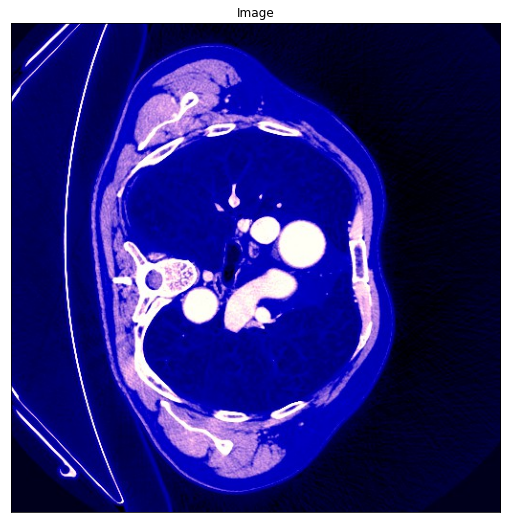

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='activation_11/Relu:0', description="created by layer 'activation_11'")


100%|██████████| 26608/26608 [45:43<00:00,  9.70it/s]


In [7]:
if __name__ == "__main__":
    
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    
    i = random.randint(0,26000)
    
    """ Dataset """
    test_frame_path = '../input/512x512-test-images/test_images/test_images'
    

    test_x = load_data_test(test_frame_path)
    visualize(image = read_image(test_x[i]))
    
    
    #hyperparameters
    shape = (512,512,3)
    classes = 3
    lr = 1e-4
    batch_size = 64
    epochs = 2
    
    """ Model """
    model = build_unet(shape, classes)
    model.compile(loss= dice_coef_loss, optimizer=tf.keras.optimizers.Adam(lr))
#     #model.summary()
    model.load_weights('../input/512x512-mfp-fsm-res-unet/best_model5.h5')
    
    for x in tqdm(test_x, total = len(test_x)):
        name = x.split('/')[-1]
        name = name.replace('.jpg', '.tiff')
        
    
        x = read_image(x)
        
        p = model.predict(np.expand_dims(x,axis=0))[0]
        p = np.argmax(p, axis=-1)
        #print(np.unique(p, return_counts=True))
        p = np.expand_dims(p, axis=-1)
        p = p.astype(np.int32)
        p = np.squeeze(p, axis=-1)
        
        img = Image.fromarray(p.astype('uint8'), mode = 'L')
        img.save(f"./test_masks/{name}")
        


In [8]:
# i = random.randint(0,26000)

# #masks = os.listdir('./test_masks')

# #mask = masks[i]

# images = mask.replace('.tiff','.jpg')

# image_path = '../input/test-images-lits-256x256/test_images/test_images'

# image_path = os.path.join(image_path, image)
# mask_path = os.path.join('./test_masks', mask)

# img = plt.imread(image_path)
# mask = plt.imread(mask_path)

# visualize(image = img, mask = mask)


In [9]:

i = random.randint(0,26000)

#masks = os.listdir('./test_masks')

#mask = masks[i]

image_path = '../input/test-images-lits-256x256/test_images/test_images'
mask_path = '../input/test-masks-unet-keras-depth-4/test_masks'

images = os.listdir(image_path)

image = images[i]
mask = image.replace('.jpg', '.tiff')

image_path = os.path.join(image_path, image)
mask_path = os.path.join(mask_path, mask)

img = plt.imread(image_path)
mask = plt.imread(mask_path)

visualize(image = img, mask = mask)


FileNotFoundError: [Errno 2] No such file or directory: '../input/test-images-lits-256x256/test_images/test_images'

In [10]:
!zip -r test_masks.zip "./test_masks"

  adding: test_masks/ (stored 0%)
  adding: test_masks/test-volume-18_slice_38.tiff (deflated 100%)
  adding: test_masks/test-volume-53_slice_273.tiff (deflated 100%)
  adding: test_masks/test-volume-17_slice_293.tiff (deflated 100%)
  adding: test_masks/test-volume-36_slice_399.tiff (deflated 100%)
  adding: test_masks/test-volume-60_slice_165.tiff (deflated 100%)
  adding: test_masks/test-volume-36_slice_121.tiff (deflated 100%)
  adding: test_masks/test-volume-40_slice_27.tiff (deflated 100%)
  adding: test_masks/test-volume-64_slice_139.tiff (deflated 100%)
  adding: test_masks/test-volume-38_slice_566.tiff (deflated 99%)
  adding: test_masks/test-volume-56_slice_528.tiff (deflated 100%)
  adding: test_masks/test-volume-38_slice_586.tiff (deflated 99%)
  adding: test_masks/test-volume-57_slice_453.tiff (deflated 99%)
  adding: test_masks/test-volume-20_slice_208.tiff (deflated 100%)
  adding: test_masks/test-volume-61_slice_397.tiff (deflated 100%)
  adding: test_masks/test-volume-

In [11]:
import shutil
shutil.rmtree('./test_masks')